In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random

import mlflow
import segmentation_models_pytorch as smp
import torch
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage


from cosas.tracking import get_experiment
from cosas.paths import DATA_DIR
from cosas.data_model import COSASData, Scanncers
from cosas.datasets import Patchdataset
from cosas.misc import set_seed, train_val_split

/home/heon/anaconda3/envs/cosas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

DEVICE = "cuda"
# experiment = get_experiment()
set_seed(42)  # TODO

cosas_data = COSASData(os.path.join(DATA_DIR, "task2"))
cosas_data.load()

(train_images, train_masks), (val_images, val_masks), (test_images, test_masks) = (
    train_val_split(cosas_data, train_val_test=(0.6, 0.2, 0.2))
)

model = smp.FPN(
    encoder_name="efficientnet-b0",
    encoder_weights="imagenet",
    classes=1,
    activation=None,
).to(DEVICE)


Wholedataset

TypeError: Image data of dtype object cannot be converted to float

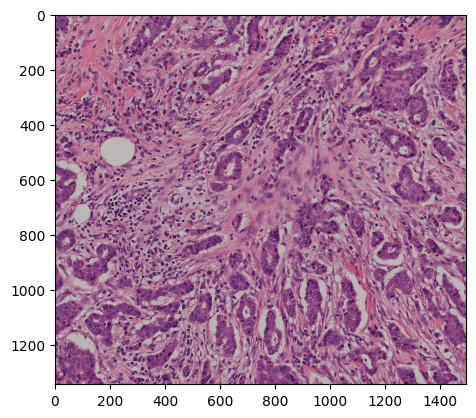

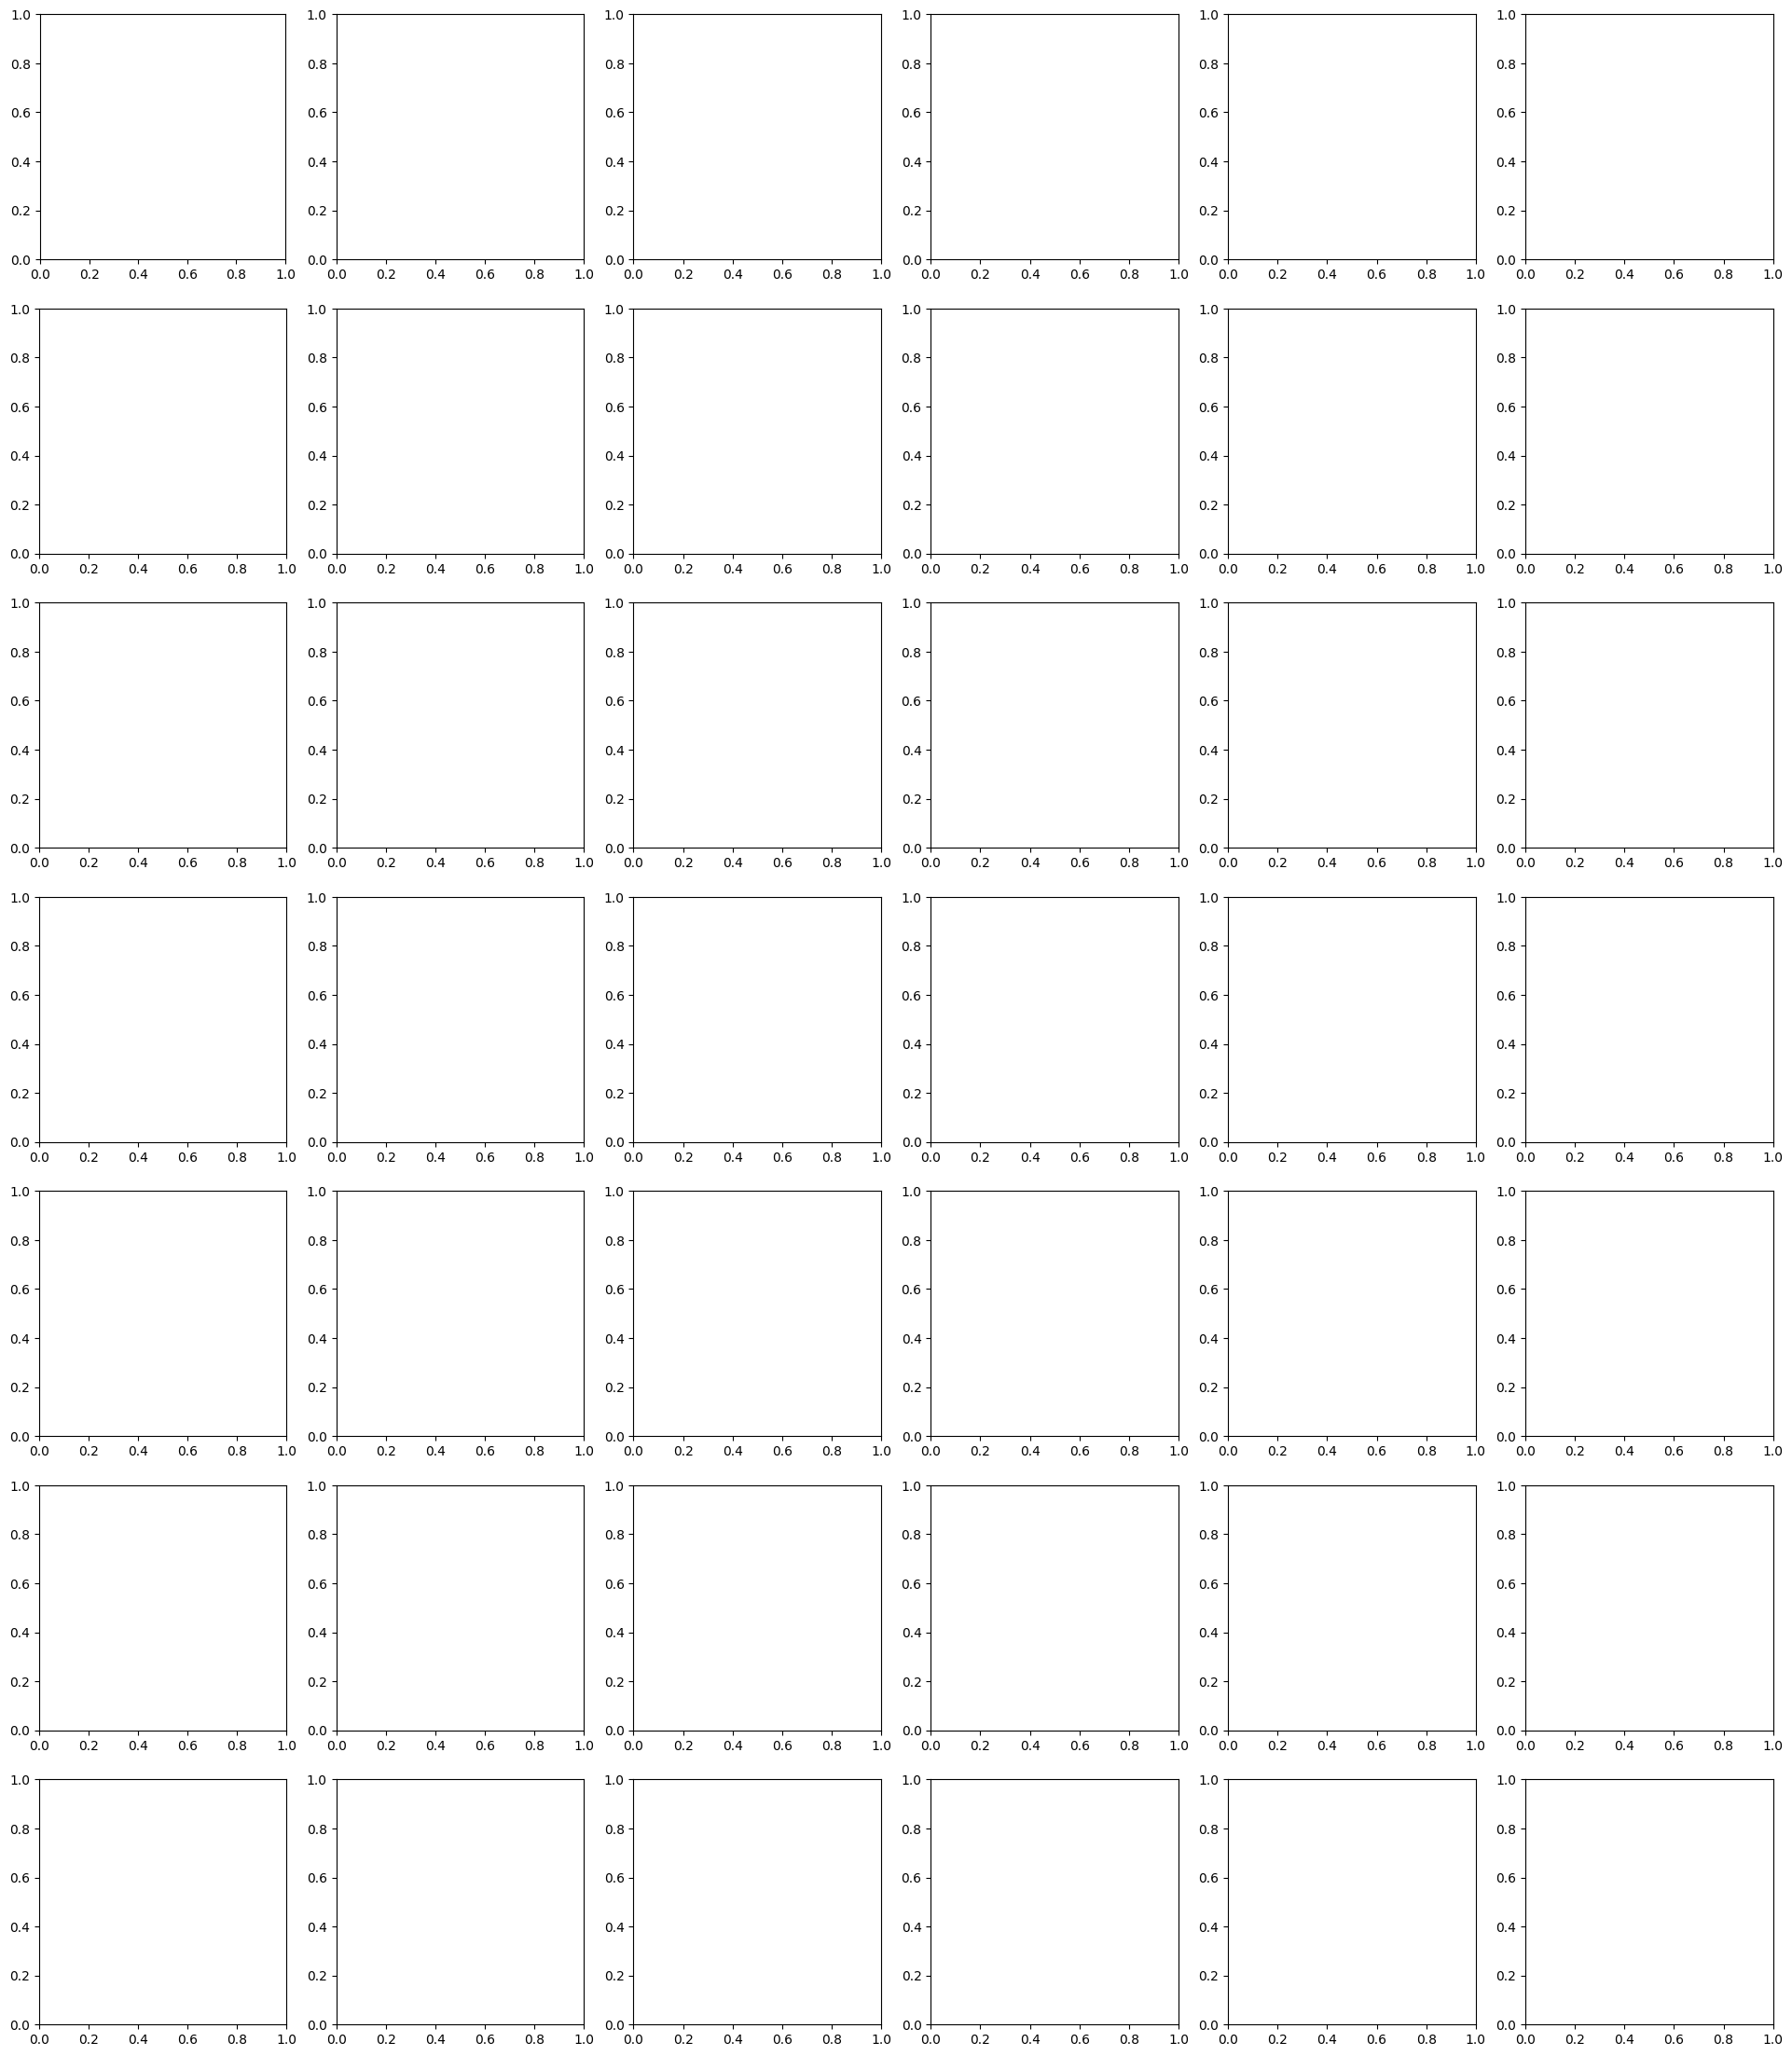

In [48]:
from PIL import Image
from matplotlib import pyplot as plt
from torchvision.transforms.functional import pad
from cosas.datasets import WholeSizeDataset
wholesize_ds = WholeSizeDataset(train_images, train_masks)
image, mask = wholesize_ds[0]

patches = wholesize_ds._tesellation(image)
batch = patches.shape[0]

plt.imshow(image)
fig, axes = plt.subplots(7, 6, figsize=(4*6, 4*7))
for i in range(batch):
    ax = axes[i % 7, i % 6] 
    ax.imshow(patches[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [4]:
import torch
from torch.utils.data import DataLoader
from cosas.metrics import calculate_metrics, Metrics, AverageMeter
from cosas.trainer import BinaryClassifierTrainer
from cosas.tracking import TRACKING_URI, get_experiment
transform = A.Compose(
    [
        A.RandomCrop(height=224, width=224, p=1),
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # TODO: RandomRotation90 추가
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]    
)

train_dataset = COSASdataset(train_images, train_masks, transform)
train_dataloader = DataLoader(train_dataset, batch_size=4)

test_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
val_dataloader= DataLoader(
    COSASdataset(val_images, val_masks, test_transform), 
    batch_size=4
)
num_epochs = 2
n_steps = len(train_dataloader)
trainer = BinaryClassifierTrainer(
    model, 
    torch.nn.functional.binary_cross_entropy_with_logits, 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
)

mlflow.set_tracking_uri(TRACKING_URI)
experiment = get_experiment("cosas")

with mlflow.start_run(experiment_id=experiment.experiment_id, run_name="test_run") as run:
    trainer.train(
        train_dataloader,
        val_dataloader,
        10,
        7,
    )
    mlflow.pytorch.log_model(trainer.model, "model")
    
    
    test_dataloader = DataLoader(
        COSASdataset(test_images, test_masks, test_transform), 
        batch_size=4,
        shuffle=False
    )
    test_loss, test_metrics = trainer.run_epoch("test", epoch=15, dataloader=test_dataloader)
    mlflow.log_metric("test_loss", test_loss.avg)
    mlflow.log_metrics(test_metrics.to_dict(prefix="test_"))    

 |################################| train | EPOCH 0: [17/18] | eta:1 | total_loss: 0.9836 | f1: 0.6237|acc: 0.6761|sen: 0.6764|spec: 0.6779|auroc: 0.7458|prauc: 0.7231|iou: 0.4797|dice: 0.6237
 |################################| validation | EPOCH 0: [5/6] | eta:1 | total_loss: 2.0791 | f1: 0.0262|acc: 0.4877|sen: 0.0138|spec: 0.9815|auroc: 0.5028|prauc: 0.4914|iou: 0.0134|dice: 0.0262
 |################################| train | EPOCH 1: [17/18] | eta:1 | total_loss: 0.6149 | f1: 0.7573|acc: 0.7564|sen: 0.7857|spec: 0.7606|auroc: 0.8613|prauc: 0.8797|iou: 0.6186|dice: 0.7573
 |################################| validation | EPOCH 1: [5/6] | eta:1 | total_loss: 1.0344 | f1: 0.4133|acc: 0.5027|sen: 0.3805|spec: 0.6508|auroc: 0.5213|prauc: 0.5177|iou: 0.2717|dice: 0.4133
 |################################| train | EPOCH 2: [17/18] | eta:1 | total_loss: 0.6158 | f1: 0.7081|acc: 0.7278|sen: 0.7294|spec: 0.7378|auroc: 0.8471|prauc: 0.8534|iou: 0.5615|dice: 0.7081
 |###########################